In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


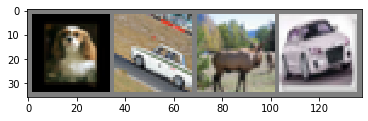

  dog   car  deer   car


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
import time

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0], data[1]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            elapsed_time = time.time() - start_time
            print('Time = ', elapsed_time)

print('Finished Training')

[1,  2000] loss: 2.135
Time =  5.912063121795654
[1,  4000] loss: 1.781
Time =  13.504640102386475
[1,  6000] loss: 1.608
Time =  19.791977405548096
[1,  8000] loss: 1.522
Time =  26.96654486656189
[1, 10000] loss: 1.460
Time =  33.850764751434326
[1, 12000] loss: 1.389
Time =  41.14464616775513
[2,  2000] loss: 1.331
Time =  5.36856484413147
[2,  4000] loss: 1.318
Time =  10.738088846206665
[2,  6000] loss: 1.260
Time =  16.669111490249634
[2,  8000] loss: 1.239
Time =  22.372043132781982
[2, 10000] loss: 1.210
Time =  28.023468255996704
[2, 12000] loss: 1.201
Time =  33.33404088020325
Finished Training


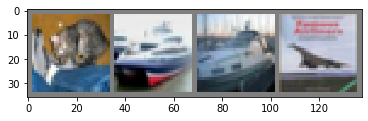

GroundTruth:    cat  ship  ship plane


In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
outputs = net(images)

In [29]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [31]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 64 %
Accuracy of  bird : 20 %
Accuracy of   cat : 34 %
Accuracy of  deer : 47 %
Accuracy of   dog : 43 %
Accuracy of  frog : 74 %
Accuracy of horse : 85 %
Accuracy of  ship : 56 %
Accuracy of truck : 73 %


In [32]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

0
Tesla K20m


In [33]:
# 이제 GPU 써 보기
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [34]:
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [35]:
import time

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            elapsed_time = time.time() - start_time
            print('Time = ', elapsed_time)

print('Finished Training')

[1,  2000] loss: 2.209
Time =  4.20701003074646
[1,  4000] loss: 1.814
Time =  8.325215339660645
[1,  6000] loss: 1.626
Time =  12.453926801681519
[1,  8000] loss: 1.516
Time =  16.6347074508667
[1, 10000] loss: 1.457
Time =  20.729477167129517
[1, 12000] loss: 1.405
Time =  24.883761882781982
[2,  2000] loss: 1.305
Time =  4.185807704925537
[2,  4000] loss: 1.294
Time =  8.412692785263062
[2,  6000] loss: 1.232
Time =  12.476936101913452
[2,  8000] loss: 1.235
Time =  16.72528862953186
[2, 10000] loss: 1.201
Time =  20.857069730758667
[2, 12000] loss: 1.190
Time =  24.945217847824097
Finished Training
